In [18]:
import math
import sys
import numpy as np
import re
import string
import random
from random import randint
import cv2
import os

from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image, ImageFont, ImageDraw
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plti

%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda/

env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda/


In [19]:
# CONSTANTS
IM_PATH = "/home/fizzer/inner_images"
CP_PATH = "/home/fizzer/cnn_trainer/inner/model_cps/"
SAVE_PATH = "/home/fizzer/cnn_trainer/inner/model_save/"
NUM_LABELS = 4
CONFIDENCE_THRESHOLD = 0.01
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 1e-4
IMG_DOWNSCALE_RATIO = 0.25
VERTICAL_CROP = 80

In [20]:
# Setup ref and read files
one_hot_ref = {
    'L': np.array([1.,0.,0.]),
    'F': np.array([0.,1.,0.]),
    'R': np.array([0.,0.,1.]),
}
# Read the images from the files 
dir_contents = np.array(os.listdir(IM_PATH))
np.random.shuffle(dir_contents)
im_set = []
for im_path in dir_contents:
    spl = im_path.split('_')
    x_vel = float(spl[0])
    z_vel = float(spl[1])
    #TODO: confirm labels
    if (x_vel > 0):
        label = one_hot_ref['F']
    elif (z_vel > 0):
        label = one_hot_ref['L']
    elif (z_vel < 0):
        label = one_hot_ref['R']
    img = cv2.cvtColor(cv2.imread(f"{IM_PATH}/{im_path}"), cv2.COLOR_RGB2GRAY)
    im_set.append([label, cv2.resize(img, (0,0), fx=IMG_DOWNSCALE_RATIO, fy=IMG_DOWNSCALE_RATIO)])
# im_set = np.array(im_set, dtype=object)

In [21]:
# Create x_dataset and y_dataset
x_dataset = np.array([img[1][:] for img in im_set[:]])
y_dataset = np.array([img[0] for img in im_set[:]])
x_dataset = x_dataset/255.0
del(im_set)
# TODO: may need this x_dataset = x_dataset.reshape(len(x_dataset), len(x_dataset[0]), len(x_dataset[0][0]),-1)

(1128, 180, 320)


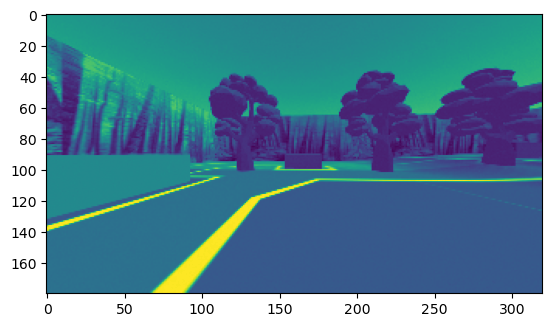

In [22]:
print(x_dataset.shape)
plt.imshow(x_dataset[0]*255.)

In [23]:
# TODO: The following was copy pasted - validate
def reset_weights(model):
    for ix, layer in enumerate(model.layers):
        if (hasattr(model.layers[ix], 'kernel_initializer') and 
            hasattr(model.layers[ix], 'bias_initializer')):
            weight_initializer = model.layers[ix].kernel_initializer
            bias_initializer = model.layers[ix].bias_initializer

            old_weights, old_biases = model.layers[ix].get_weights()

            model.layers[ix].set_weights([
                weight_initializer(shape=old_weights.shape),
                bias_initializer(shape=len(old_biases))])

In [24]:
# Set up CNN
def create_model():
    conv_model = models.Sequential()
    conv_model.add(layers.Conv2D(3, (5, 5), activation='relu',
                            input_shape=(x_dataset.shape[1], x_dataset.shape[2], 1)))
    conv_model.add(layers.MaxPooling2D((2, 2)))
    conv_model.add(layers.Conv2D(24, (5, 5), activation='relu'))
    conv_model.add(layers.MaxPooling2D((2, 2)))
    conv_model.add(layers.Conv2D(36, (5, 5), activation='relu'))
    conv_model.add(layers.MaxPooling2D((2, 2)))
    conv_model.add(layers.Conv2D(48, (3, 3), activation='relu'))
    conv_model.add(layers.MaxPooling2D((2, 2)))
    conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    conv_model.add(layers.MaxPooling2D((2, 2)))
    conv_model.add(layers.Flatten())
    conv_model.add(layers.Dropout(0.5))
    conv_model.add(layers.Dense(512, activation='relu'))
    conv_model.add(layers.Dense(50, activation='relu'))
    conv_model.add(layers.Dense(10, activation='relu'))
    conv_model.add(layers.Dense(3, activation='softmax'))
    conv_model.compile(loss='mse', optimizer=optimizers.RMSprop(learning_rate=LEARNING_RATE), metrics=['acc'])
    return conv_model

conv_model = create_model()
cp_callback = callbacks.ModelCheckpoint(filepath=CP_PATH, save_weights_only=True, verbose=1)


In [25]:
# reset_weights(conv_model)

In [26]:
# # Train CNN
# begin = 0
# block_length = len(x_dataset) // 5
# for i in range(block_length, len(x_dataset), block_length):
#     history_conv = conv_model.fit(x_dataset[begin:block_length], y_dataset[begin:block_length], 
#                                 validation_split=VALIDATION_SPLIT, 
#                                 epochs=20, 
#                                 batch_size=16)
#     x_dataset = x_dataset[block_length:]
#     y_dataset = y_dataset[block_length:]

In [27]:
# Train CNN
history_conv = conv_model.fit(x_dataset, y_dataset, 
                                 validation_split=VALIDATION_SPLIT, 
                                 epochs=50, 
                                 batch_size=16,
                                 callbacks=[cp_callback])

Epoch 1/50
57/57 [==============================] - ETA: 0s - loss: 0.2157 - acc: 0.4590
Epoch 1: saving model to /home/fizzer/cnn_trainer/inner/model_cps/
57/57 [==============================] - 2s 13ms/step - loss: 0.2157 - acc: 0.4590 - val_loss: 0.2111 - val_acc: 0.4690
Epoch 2/50
55/57 [===========================>..] - ETA: 0s - loss: 0.2091 - acc: 0.4659
Epoch 2: saving model to /home/fizzer/cnn_trainer/inner/model_cps/
57/57 [==============================] - 0s 7ms/step - loss: 0.2096 - acc: 0.4612 - val_loss: 0.2011 - val_acc: 0.4823
Epoch 3/50
55/57 [===========================>..] - ETA: 0s - loss: 0.2002 - acc: 0.4909
Epoch 3: saving model to /home/fizzer/cnn_trainer/inner/model_cps/
57/57 [==============================] - 0s 7ms/step - loss: 0.1995 - acc: 0.4922 - val_loss: 0.1909 - val_acc: 0.5310
Epoch 4/50
55/57 [===========================>..] - ETA: 0s - loss: 0.1888 - acc: 0.5193
Epoch 4: saving model to /home/fizzer/cnn_trainer/inner/model_cps/
57/57 [===========

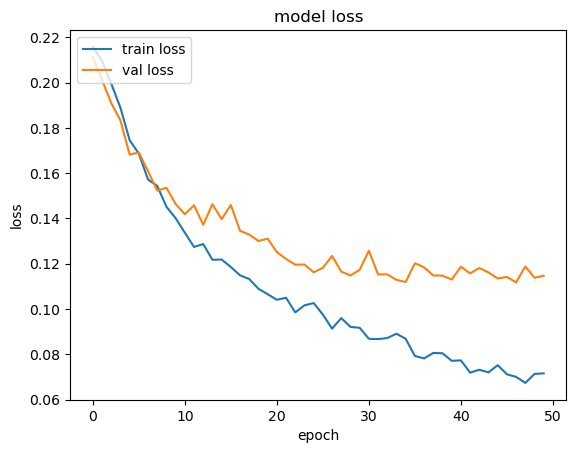

In [28]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

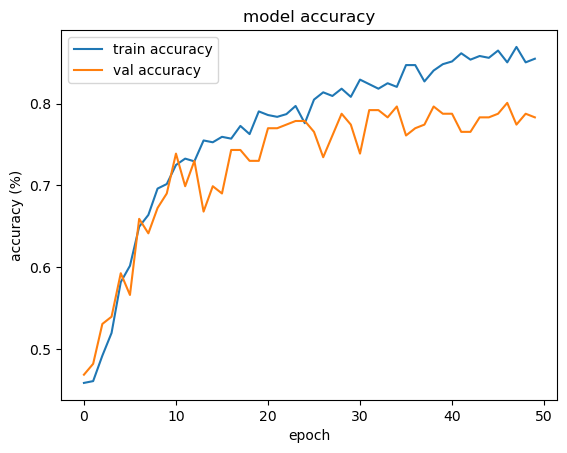

In [29]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [30]:
from sklearn.metrics import confusion_matrix

36/36 [==============================] - 0s 5ms/step


<AxesSubplot:>

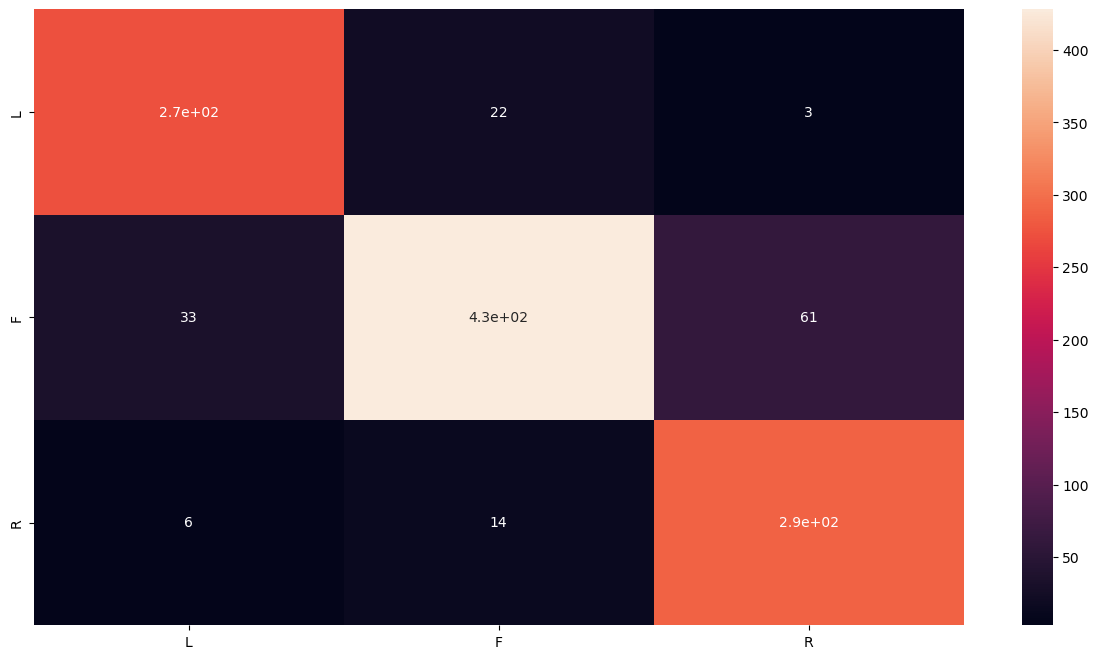

In [31]:
pred_matrix = conv_model.predict(x_dataset)

pred_results = [np.argmax(pred) for pred in pred_matrix]
corr_results = [np.argmax(y_val) for y_val in y_dataset]

conf_matrix = confusion_matrix(corr_results, pred_results)

df_cm = pd.DataFrame(conf_matrix, index = [val for i, val in enumerate(one_hot_ref) if i < 4],
                  columns = [val for i, val in enumerate(one_hot_ref) if i < 4])
plt.figure(figsize = (15,8))
sn.heatmap(df_cm, annot=True)

In [32]:
conv_model.save(SAVE_PATH)

INFO:tensorflow:Assets written to: /home/fizzer/cnn_trainer/inner/model_save/assets


INFO:tensorflow:Assets written to: /home/fizzer/cnn_trainer/inner/model_save/assets


In [33]:
new_model = models.load_model(SAVE_PATH)

36/36 [==============================] - 0s 3ms/step


<AxesSubplot:>

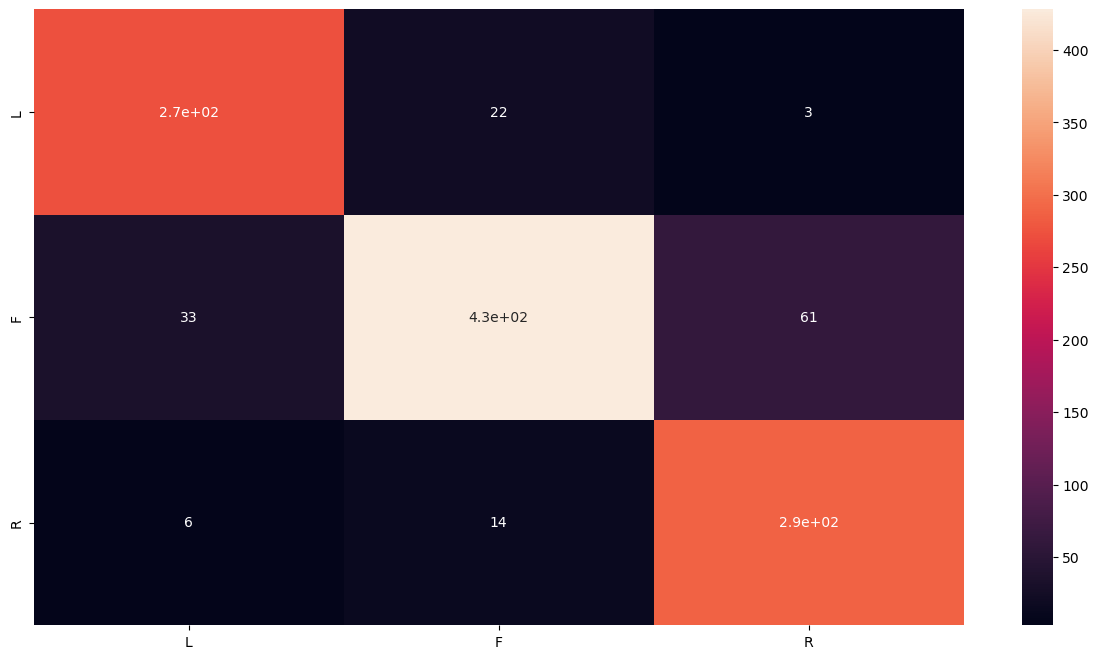

In [34]:
from sklearn.metrics import confusion_matrix
pred_matrix = new_model.predict(x_dataset)

pred_results = [np.argmax(pred) for pred in pred_matrix]
corr_results = [np.argmax(y_val) for y_val in y_dataset]

conf_matrix = confusion_matrix(corr_results, pred_results)

df_cm = pd.DataFrame(conf_matrix, index = [val for i, val in enumerate(one_hot_ref) if i < 3],
                  columns = [val for i, val in enumerate(one_hot_ref) if i < 3])
plt.figure(figsize = (15,8))
sn.heatmap(df_cm, annot=True)